# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [68]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

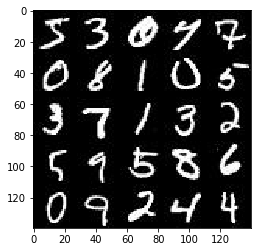

In [69]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

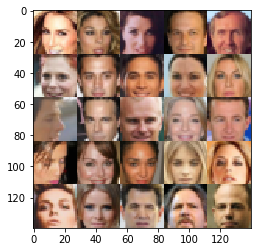

In [70]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [71]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [72]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='real_inputs')
    inputs_z = tf.placeholder(tf.float32,(None,z_dim),name='z_inputs')
    lr = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [207]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.1
    
    with tf.variable_scope('discriminator',reuse=reuse):
        #print(images.shape)
        # 28 x 28 x 3
        x1 = tf.layers.conv2d(images, 128, (5,5), padding='same', strides=(2,2), data_format='channels_last')
        x1 = tf.maximum(x1,alpha*x1)
        #print(x1.shape)
        
        # 14 x 14 x 128
        x2 = tf.layers.conv2d(x1, 256, (5,5), padding='same', strides=(2,2), data_format='channels_last')
        x2 = tf.layers.batch_normalization(x2,training=True)
        x2 = tf.maximum(x2,alpha*x2)
        #print(x2.shape)

        # 7 x 7 x 256
        x3 = tf.layers.conv2d(x2, 512, (5,5), padding='same', strides=(2,2), data_format='channels_last')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3,alpha*x3)
        
        # print()
        flat = tf.reshape(x2,(-1,7*7*1024))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [209]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    reuse = not is_train
    
    with tf.variable_scope('generator',reuse=reuse):
        x0 = tf.layers.dense(z,7*7*512)
        x0 = tf.reshape(x0,(-1,7,7,512))
        x0 = tf.layers.batch_normalization(x0,training=is_train)
        x0 = tf.maximum(alpha*x0,x0)
        #print(x0.shape)
        # 7 x 7 x 512
        
        x1 = tf.layers.conv2d_transpose(x0,256,5,strides=2,padding='same')
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(alpha*x1,x1)
        #print(x1.shape)
        # 14 x 14 x 256
        
        x2 = tf.layers.conv2d_transpose(x1,128,5,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(alpha*x2,x2)
        #print(x2.shape)
        # 28 x 28 x 128
        
        logits = tf.layers.conv2d_transpose(x2,out_channel_dim,5,strides=1,padding='same')
        #print(logits.shape)
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [210]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    #print(g_model.shape)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    #print(input_real.shape)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # GENERATOR LOSS
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    # REAL DISCRIMINATOR LOSS
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    # FAKE DISCRIMINATOR LOSS
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    # SUM
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [211]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [212]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [213]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    print(data_shape)
    image_width, image_height, image_channels = data_shape[1:]
    inputs_real, inputs_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, image_channels, size=(batch_size, z_dim))
                
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr:learning_rate})
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr:learning_rate})
                
                if steps % 20 is 0:
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    train_loss_d = d_loss.eval({inputs_real: batch_images, inputs_z: batch_z})
                    print('Epoch {}, Steps completed: {}, Losses: Gntr {:.4f}, Dsctr {:.4f}'.format(epoch_i,steps,train_loss_g,train_loss_d))
                if steps % 100 is 0:
                    show_generator_output(sess, 9, inputs_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 0, Steps completed: 20, Losses: Gntr 40.3411, Dsctr 39.2142
Epoch 0, Steps completed: 40, Losses: Gntr 10.9908, Dsctr 0.0000
Epoch 0, Steps completed: 60, Losses: Gntr 30.2017, Dsctr 2.6043
Epoch 0, Steps completed: 80, Losses: Gntr 14.0456, Dsctr 0.6995
Epoch 0, Steps completed: 100, Losses: Gntr 25.1947, Dsctr 0.0075


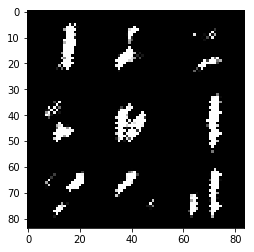

Epoch 0, Steps completed: 120, Losses: Gntr 17.7965, Dsctr 0.0006
Epoch 0, Steps completed: 140, Losses: Gntr 10.3781, Dsctr 0.0003
Epoch 0, Steps completed: 160, Losses: Gntr 25.3132, Dsctr 0.0000
Epoch 0, Steps completed: 180, Losses: Gntr 29.6481, Dsctr 0.0000
Epoch 0, Steps completed: 200, Losses: Gntr 24.4865, Dsctr 0.0056


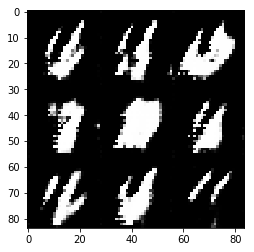

Epoch 0, Steps completed: 220, Losses: Gntr 10.6329, Dsctr 0.0040
Epoch 0, Steps completed: 240, Losses: Gntr 19.7192, Dsctr 0.0026
Epoch 0, Steps completed: 260, Losses: Gntr 35.0531, Dsctr 0.0000
Epoch 0, Steps completed: 280, Losses: Gntr 22.9788, Dsctr 3.3687
Epoch 0, Steps completed: 300, Losses: Gntr 17.1625, Dsctr 0.0068


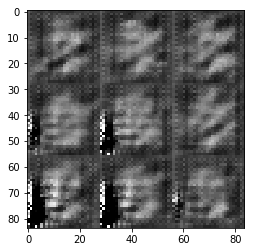

Epoch 0, Steps completed: 320, Losses: Gntr 24.8238, Dsctr 0.1595
Epoch 0, Steps completed: 340, Losses: Gntr 34.3168, Dsctr 2.3131
Epoch 0, Steps completed: 360, Losses: Gntr 20.5051, Dsctr 0.3803
Epoch 0, Steps completed: 380, Losses: Gntr 40.4774, Dsctr 3.6519
Epoch 0, Steps completed: 400, Losses: Gntr 13.1473, Dsctr 0.0240


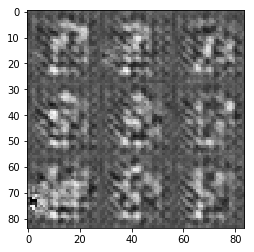

Epoch 0, Steps completed: 420, Losses: Gntr 2.9797, Dsctr 2.8996
Epoch 0, Steps completed: 440, Losses: Gntr 27.0023, Dsctr 0.5780
Epoch 0, Steps completed: 460, Losses: Gntr 21.3096, Dsctr 0.0031
Epoch 0, Steps completed: 480, Losses: Gntr 24.2165, Dsctr 0.0004
Epoch 0, Steps completed: 500, Losses: Gntr 16.9055, Dsctr 0.4711


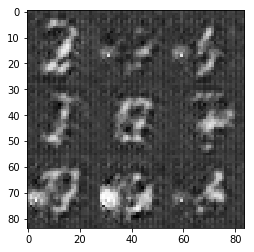

Epoch 0, Steps completed: 520, Losses: Gntr 16.3632, Dsctr 5.2071
Epoch 0, Steps completed: 540, Losses: Gntr 6.7768, Dsctr 0.9398
Epoch 0, Steps completed: 560, Losses: Gntr 16.0544, Dsctr 7.3177
Epoch 0, Steps completed: 580, Losses: Gntr 11.6305, Dsctr 0.4617
Epoch 0, Steps completed: 600, Losses: Gntr 18.9970, Dsctr 4.7303


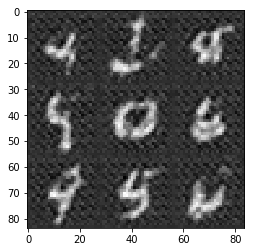

Epoch 0, Steps completed: 620, Losses: Gntr 15.2487, Dsctr 0.2690
Epoch 0, Steps completed: 640, Losses: Gntr 11.3848, Dsctr 1.2229
Epoch 0, Steps completed: 660, Losses: Gntr 0.6348, Dsctr 1.9843
Epoch 0, Steps completed: 680, Losses: Gntr 6.9951, Dsctr 2.1608
Epoch 0, Steps completed: 700, Losses: Gntr 8.1653, Dsctr 2.3159


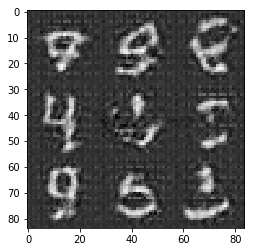

Epoch 0, Steps completed: 720, Losses: Gntr 2.6944, Dsctr 0.5635
Epoch 0, Steps completed: 740, Losses: Gntr 7.6866, Dsctr 2.4674
Epoch 0, Steps completed: 760, Losses: Gntr 0.8121, Dsctr 2.4887
Epoch 0, Steps completed: 780, Losses: Gntr 0.5900, Dsctr 1.9274
Epoch 0, Steps completed: 800, Losses: Gntr 1.5128, Dsctr 0.7797


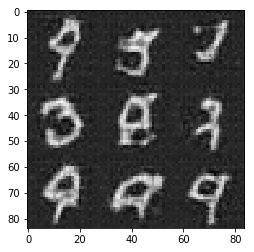

Epoch 0, Steps completed: 820, Losses: Gntr 3.2203, Dsctr 0.1802
Epoch 0, Steps completed: 840, Losses: Gntr 0.2997, Dsctr 3.1608
Epoch 0, Steps completed: 860, Losses: Gntr 3.1471, Dsctr 0.2533
Epoch 0, Steps completed: 880, Losses: Gntr 10.2863, Dsctr 2.0368
Epoch 0, Steps completed: 900, Losses: Gntr 9.5374, Dsctr 3.2793


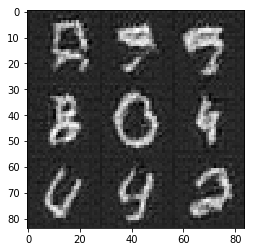

Epoch 0, Steps completed: 920, Losses: Gntr 7.9136, Dsctr 2.2194
Epoch 1, Steps completed: 940, Losses: Gntr 2.4232, Dsctr 0.2539
Epoch 1, Steps completed: 960, Losses: Gntr 2.6250, Dsctr 0.3161
Epoch 1, Steps completed: 980, Losses: Gntr 0.8139, Dsctr 1.0538
Epoch 1, Steps completed: 1000, Losses: Gntr 8.4308, Dsctr 3.6782


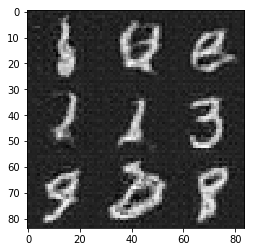

Epoch 1, Steps completed: 1020, Losses: Gntr 3.1113, Dsctr 0.1600
Epoch 1, Steps completed: 1040, Losses: Gntr 4.0069, Dsctr 0.1984
Epoch 1, Steps completed: 1060, Losses: Gntr 7.3953, Dsctr 2.8742
Epoch 1, Steps completed: 1080, Losses: Gntr 7.9604, Dsctr 2.5187
Epoch 1, Steps completed: 1100, Losses: Gntr 0.6924, Dsctr 1.5290


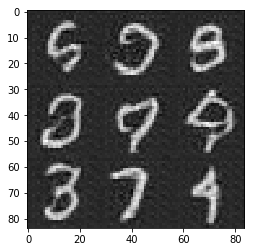

Epoch 1, Steps completed: 1120, Losses: Gntr 1.3168, Dsctr 0.7584
Epoch 1, Steps completed: 1140, Losses: Gntr 1.2389, Dsctr 0.8055
Epoch 1, Steps completed: 1160, Losses: Gntr 6.7311, Dsctr 1.1765
Epoch 1, Steps completed: 1180, Losses: Gntr 1.4985, Dsctr 0.9965
Epoch 1, Steps completed: 1200, Losses: Gntr 0.5057, Dsctr 1.6025


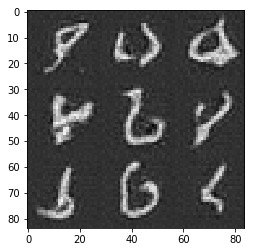

Epoch 1, Steps completed: 1220, Losses: Gntr 7.6597, Dsctr 1.7938
Epoch 1, Steps completed: 1240, Losses: Gntr 0.7847, Dsctr 1.5318
Epoch 1, Steps completed: 1260, Losses: Gntr 6.7380, Dsctr 2.3685
Epoch 1, Steps completed: 1280, Losses: Gntr 0.8472, Dsctr 1.2963
Epoch 1, Steps completed: 1300, Losses: Gntr 8.5975, Dsctr 2.9848


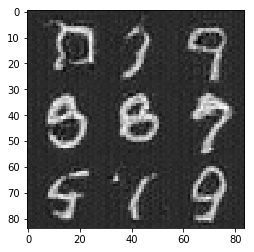

Epoch 1, Steps completed: 1320, Losses: Gntr 6.9556, Dsctr 2.6153
Epoch 1, Steps completed: 1340, Losses: Gntr 6.4473, Dsctr 1.8330
Epoch 1, Steps completed: 1360, Losses: Gntr 0.2093, Dsctr 2.6661
Epoch 1, Steps completed: 1380, Losses: Gntr 1.5720, Dsctr 1.0409
Epoch 1, Steps completed: 1400, Losses: Gntr 2.2599, Dsctr 0.6510


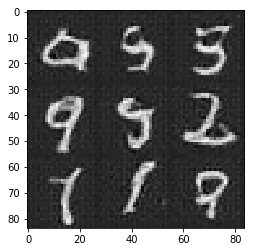

Epoch 1, Steps completed: 1420, Losses: Gntr 4.7167, Dsctr 1.5496
Epoch 1, Steps completed: 1440, Losses: Gntr 2.1096, Dsctr 0.2750
Epoch 1, Steps completed: 1460, Losses: Gntr 6.7504, Dsctr 2.8659
Epoch 1, Steps completed: 1480, Losses: Gntr 0.3586, Dsctr 1.5471
Epoch 1, Steps completed: 1500, Losses: Gntr 5.6969, Dsctr 1.3265


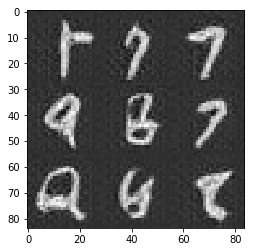

Epoch 1, Steps completed: 1520, Losses: Gntr 0.7259, Dsctr 1.0733
Epoch 1, Steps completed: 1540, Losses: Gntr 1.1386, Dsctr 0.6122
Epoch 1, Steps completed: 1560, Losses: Gntr 0.9138, Dsctr 1.1173
Epoch 1, Steps completed: 1580, Losses: Gntr 4.7070, Dsctr 1.6602
Epoch 1, Steps completed: 1600, Losses: Gntr 6.6536, Dsctr 2.5501


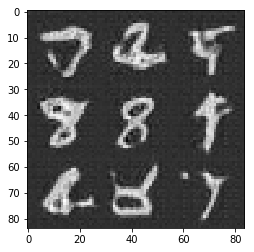

Epoch 1, Steps completed: 1620, Losses: Gntr 7.4956, Dsctr 1.7116
Epoch 1, Steps completed: 1640, Losses: Gntr 3.7907, Dsctr 1.0386
Epoch 1, Steps completed: 1660, Losses: Gntr 2.8375, Dsctr 0.3719
Epoch 1, Steps completed: 1680, Losses: Gntr 8.0346, Dsctr 2.6945
Epoch 1, Steps completed: 1700, Losses: Gntr 1.7572, Dsctr 0.6076


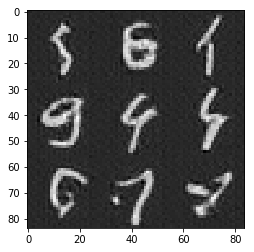

Epoch 1, Steps completed: 1720, Losses: Gntr 6.5782, Dsctr 2.0281
Epoch 1, Steps completed: 1740, Losses: Gntr 0.7298, Dsctr 0.9460
Epoch 1, Steps completed: 1760, Losses: Gntr 5.5183, Dsctr 1.5559
Epoch 1, Steps completed: 1780, Losses: Gntr 0.8209, Dsctr 0.7436
Epoch 1, Steps completed: 1800, Losses: Gntr 6.3125, Dsctr 2.6676


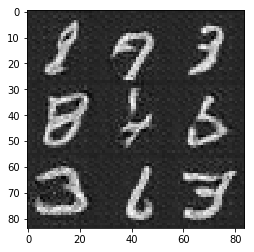

Epoch 1, Steps completed: 1820, Losses: Gntr 3.0827, Dsctr 0.4648
Epoch 1, Steps completed: 1840, Losses: Gntr 1.6794, Dsctr 0.3164
Epoch 1, Steps completed: 1860, Losses: Gntr 6.0036, Dsctr 2.1484


In [214]:
batch_size = 64
z_dim = 100
learning_rate = .002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch 0, Steps completed: 20, Losses: Gntr 55.7920, Dsctr 0.3088
Epoch 0, Steps completed: 40, Losses: Gntr 83.5113, Dsctr 5.9525
Epoch 0, Steps completed: 60, Losses: Gntr 10.2386, Dsctr 0.0000
Epoch 0, Steps completed: 80, Losses: Gntr 7.5143, Dsctr 0.0005
Epoch 0, Steps completed: 100, Losses: Gntr 9.5264, Dsctr 0.0001


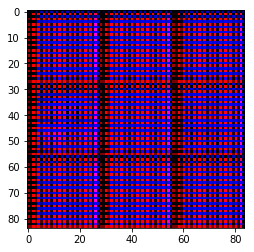

Epoch 0, Steps completed: 120, Losses: Gntr 83.6926, Dsctr 0.0000
Epoch 0, Steps completed: 140, Losses: Gntr 76.9756, Dsctr 0.0000
Epoch 0, Steps completed: 160, Losses: Gntr 74.8083, Dsctr 0.0000
Epoch 0, Steps completed: 180, Losses: Gntr 120.3415, Dsctr 1.2952
Epoch 0, Steps completed: 200, Losses: Gntr 108.8252, Dsctr 0.0000


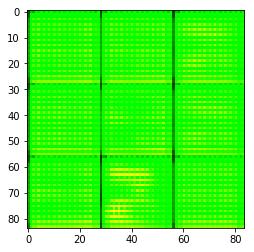

Epoch 0, Steps completed: 220, Losses: Gntr 110.7537, Dsctr 0.1108
Epoch 0, Steps completed: 240, Losses: Gntr 85.8420, Dsctr 0.0000
Epoch 0, Steps completed: 260, Losses: Gntr 83.3139, Dsctr 0.0000
Epoch 0, Steps completed: 280, Losses: Gntr 161.6700, Dsctr 0.0000
Epoch 0, Steps completed: 300, Losses: Gntr 176.7554, Dsctr 0.0000


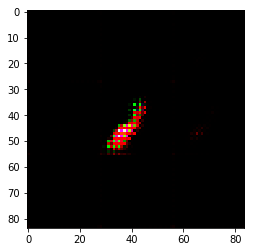

Epoch 0, Steps completed: 320, Losses: Gntr 52.9137, Dsctr 0.0000
Epoch 0, Steps completed: 340, Losses: Gntr 137.5245, Dsctr 0.0000
Epoch 0, Steps completed: 360, Losses: Gntr 21.5271, Dsctr 0.0000
Epoch 0, Steps completed: 380, Losses: Gntr 32.5023, Dsctr 0.0000
Epoch 0, Steps completed: 400, Losses: Gntr 40.4588, Dsctr 0.0000


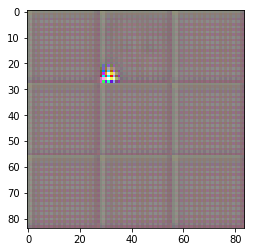

Epoch 0, Steps completed: 420, Losses: Gntr 64.9157, Dsctr 0.0000
Epoch 0, Steps completed: 440, Losses: Gntr 66.8479, Dsctr 0.0000
Epoch 0, Steps completed: 460, Losses: Gntr 87.0514, Dsctr 0.0000
Epoch 0, Steps completed: 480, Losses: Gntr 21.3379, Dsctr 0.0000
Epoch 0, Steps completed: 500, Losses: Gntr 40.9239, Dsctr 0.0000


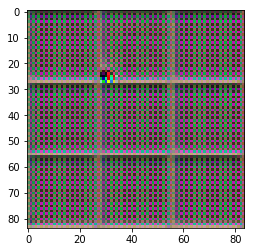

Epoch 0, Steps completed: 520, Losses: Gntr 22.1340, Dsctr 0.0000
Epoch 0, Steps completed: 540, Losses: Gntr 24.3965, Dsctr 0.0000
Epoch 0, Steps completed: 560, Losses: Gntr 14.7452, Dsctr 0.0000
Epoch 0, Steps completed: 580, Losses: Gntr 10.5126, Dsctr 0.0002
Epoch 0, Steps completed: 600, Losses: Gntr 11.7629, Dsctr 0.0000


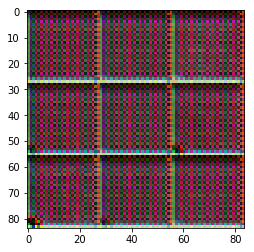

Epoch 0, Steps completed: 620, Losses: Gntr 14.1882, Dsctr 0.0000
Epoch 0, Steps completed: 640, Losses: Gntr 113.7096, Dsctr 50.4483
Epoch 0, Steps completed: 660, Losses: Gntr 57.5396, Dsctr 0.0000
Epoch 0, Steps completed: 680, Losses: Gntr 13.9286, Dsctr 0.0000
Epoch 0, Steps completed: 700, Losses: Gntr 52.1944, Dsctr 0.0000


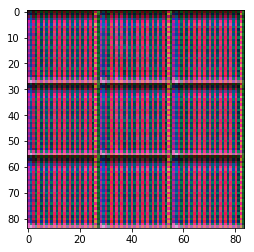

Epoch 0, Steps completed: 720, Losses: Gntr 197.0770, Dsctr 1.9829
Epoch 0, Steps completed: 740, Losses: Gntr 49.5117, Dsctr 0.0001
Epoch 0, Steps completed: 760, Losses: Gntr 69.5517, Dsctr 0.0000
Epoch 0, Steps completed: 780, Losses: Gntr 48.4495, Dsctr 0.0000
Epoch 0, Steps completed: 800, Losses: Gntr 28.8528, Dsctr 0.0000


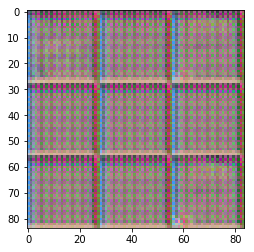

Epoch 0, Steps completed: 820, Losses: Gntr 18.5946, Dsctr 0.0000
Epoch 0, Steps completed: 840, Losses: Gntr 10.2002, Dsctr 0.0005
Epoch 0, Steps completed: 860, Losses: Gntr 55.8615, Dsctr 0.0000
Epoch 0, Steps completed: 880, Losses: Gntr 49.7386, Dsctr 0.0000
Epoch 0, Steps completed: 900, Losses: Gntr 43.9595, Dsctr 0.0000


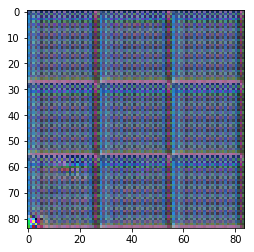

Epoch 0, Steps completed: 920, Losses: Gntr 37.9506, Dsctr 0.0000
Epoch 0, Steps completed: 940, Losses: Gntr 36.3294, Dsctr 0.0000
Epoch 0, Steps completed: 960, Losses: Gntr 25.0927, Dsctr 0.0000
Epoch 0, Steps completed: 980, Losses: Gntr 23.3624, Dsctr 0.0000
Epoch 0, Steps completed: 1000, Losses: Gntr 14.1353, Dsctr 0.0000


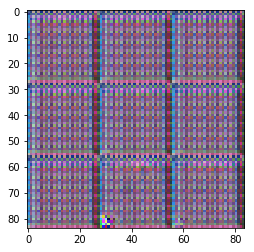

Epoch 0, Steps completed: 1020, Losses: Gntr 8.9282, Dsctr 0.0005
Epoch 0, Steps completed: 1040, Losses: Gntr 13.5760, Dsctr 0.0000
Epoch 0, Steps completed: 1060, Losses: Gntr 10.3858, Dsctr 0.0001
Epoch 0, Steps completed: 1080, Losses: Gntr 11.5309, Dsctr 0.0000
Epoch 0, Steps completed: 1100, Losses: Gntr 12.1052, Dsctr 0.0000


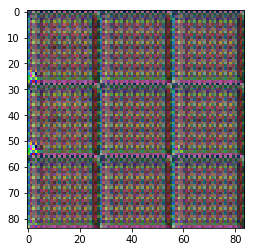

Epoch 0, Steps completed: 1120, Losses: Gntr 18.4474, Dsctr 0.0000
Epoch 0, Steps completed: 1140, Losses: Gntr 16.8984, Dsctr 0.0000
Epoch 0, Steps completed: 1160, Losses: Gntr 14.9108, Dsctr 0.0000
Epoch 0, Steps completed: 1180, Losses: Gntr 14.6265, Dsctr 0.0000
Epoch 0, Steps completed: 1200, Losses: Gntr 14.1482, Dsctr 0.0000


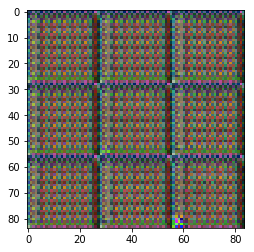

Epoch 0, Steps completed: 1220, Losses: Gntr 13.5464, Dsctr 0.0000
Epoch 0, Steps completed: 1240, Losses: Gntr 13.8790, Dsctr 0.0000
Epoch 0, Steps completed: 1260, Losses: Gntr 13.2020, Dsctr 0.0000
Epoch 0, Steps completed: 1280, Losses: Gntr 13.4355, Dsctr 0.0000
Epoch 0, Steps completed: 1300, Losses: Gntr 12.1209, Dsctr 0.0000


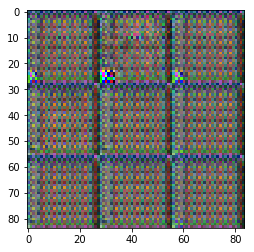

Epoch 0, Steps completed: 1320, Losses: Gntr 11.5485, Dsctr 0.0000
Epoch 0, Steps completed: 1340, Losses: Gntr 11.4745, Dsctr 0.0000
Epoch 0, Steps completed: 1360, Losses: Gntr 11.0466, Dsctr 0.0000
Epoch 0, Steps completed: 1380, Losses: Gntr 11.6968, Dsctr 0.0000
Epoch 0, Steps completed: 1400, Losses: Gntr 11.7110, Dsctr 0.0000


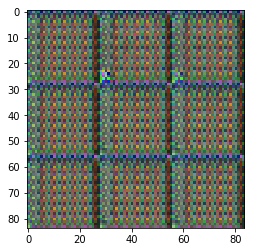

Epoch 0, Steps completed: 1420, Losses: Gntr 9.2974, Dsctr 0.0001
Epoch 0, Steps completed: 1440, Losses: Gntr 10.3094, Dsctr 0.0000
Epoch 0, Steps completed: 1460, Losses: Gntr 10.9173, Dsctr 0.0000
Epoch 0, Steps completed: 1480, Losses: Gntr 10.4655, Dsctr 0.0000
Epoch 0, Steps completed: 1500, Losses: Gntr 11.4785, Dsctr 0.0000


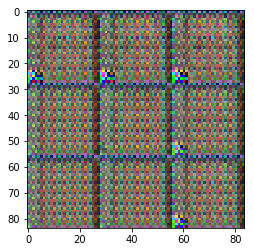

Epoch 0, Steps completed: 1520, Losses: Gntr 11.1808, Dsctr 0.0000
Epoch 0, Steps completed: 1540, Losses: Gntr 12.7304, Dsctr 0.0000
Epoch 0, Steps completed: 1560, Losses: Gntr 12.2760, Dsctr 0.0000
Epoch 0, Steps completed: 1580, Losses: Gntr 12.1865, Dsctr 0.0000
Epoch 0, Steps completed: 1600, Losses: Gntr 12.2041, Dsctr 0.0000


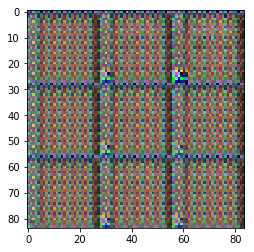

Epoch 0, Steps completed: 1620, Losses: Gntr 11.2026, Dsctr 0.0000
Epoch 0, Steps completed: 1640, Losses: Gntr 11.3613, Dsctr 0.0000
Epoch 0, Steps completed: 1660, Losses: Gntr 12.0066, Dsctr 0.0000
Epoch 0, Steps completed: 1680, Losses: Gntr 11.9248, Dsctr 0.0000
Epoch 0, Steps completed: 1700, Losses: Gntr 10.8461, Dsctr 0.0000


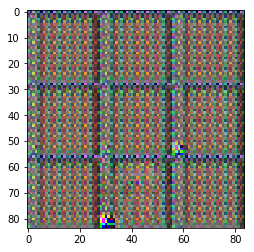

Epoch 0, Steps completed: 1720, Losses: Gntr 11.1388, Dsctr 0.0000
Epoch 0, Steps completed: 1740, Losses: Gntr 11.5514, Dsctr 0.0000
Epoch 0, Steps completed: 1760, Losses: Gntr 11.9166, Dsctr 0.0000
Epoch 0, Steps completed: 1780, Losses: Gntr 12.3153, Dsctr 0.0000
Epoch 0, Steps completed: 1800, Losses: Gntr 12.3424, Dsctr 0.0000


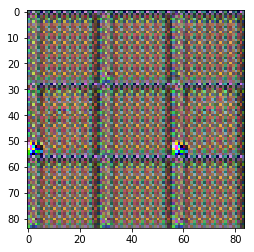

Epoch 0, Steps completed: 1820, Losses: Gntr 11.8667, Dsctr 0.0000
Epoch 0, Steps completed: 1840, Losses: Gntr 11.8699, Dsctr 0.0000
Epoch 0, Steps completed: 1860, Losses: Gntr 12.0336, Dsctr 0.0000
Epoch 0, Steps completed: 1880, Losses: Gntr 12.2909, Dsctr 0.0000
Epoch 0, Steps completed: 1900, Losses: Gntr 12.4947, Dsctr 0.0000


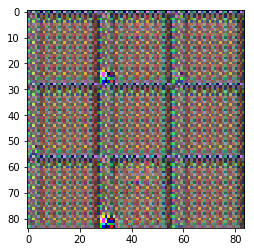

Epoch 0, Steps completed: 1920, Losses: Gntr 12.4328, Dsctr 0.0000
Epoch 0, Steps completed: 1940, Losses: Gntr 12.6407, Dsctr 0.0000
Epoch 0, Steps completed: 1960, Losses: Gntr 12.4593, Dsctr 0.0000
Epoch 0, Steps completed: 1980, Losses: Gntr 12.7948, Dsctr 0.0000
Epoch 0, Steps completed: 2000, Losses: Gntr 13.4015, Dsctr 0.0000


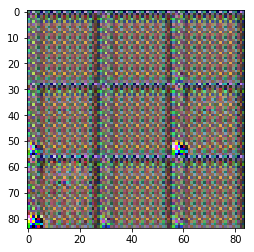

Epoch 0, Steps completed: 2020, Losses: Gntr 12.9698, Dsctr 0.0000
Epoch 0, Steps completed: 2040, Losses: Gntr 15.4770, Dsctr 0.0000
Epoch 0, Steps completed: 2060, Losses: Gntr 69.3591, Dsctr 0.0000
Epoch 0, Steps completed: 2080, Losses: Gntr 42.8862, Dsctr 0.0000
Epoch 0, Steps completed: 2100, Losses: Gntr 36.6388, Dsctr 0.0000


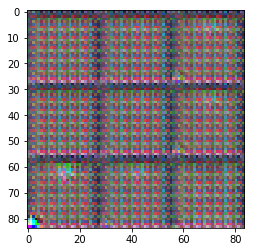

Epoch 0, Steps completed: 2120, Losses: Gntr 32.7621, Dsctr 0.0000
Epoch 0, Steps completed: 2140, Losses: Gntr 30.5924, Dsctr 0.0000
Epoch 0, Steps completed: 2160, Losses: Gntr 25.0808, Dsctr 0.0000
Epoch 0, Steps completed: 2180, Losses: Gntr 19.0573, Dsctr 0.0000
Epoch 0, Steps completed: 2200, Losses: Gntr 16.2380, Dsctr 0.0000


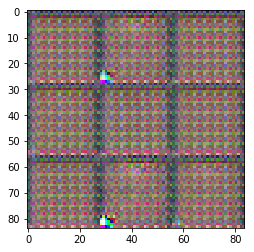

Epoch 0, Steps completed: 2220, Losses: Gntr 15.0363, Dsctr 0.0000
Epoch 0, Steps completed: 2240, Losses: Gntr 15.1440, Dsctr 0.0000
Epoch 0, Steps completed: 2260, Losses: Gntr 12.9790, Dsctr 0.0000
Epoch 0, Steps completed: 2280, Losses: Gntr 11.9530, Dsctr 0.0000
Epoch 0, Steps completed: 2300, Losses: Gntr 11.5065, Dsctr 0.0002


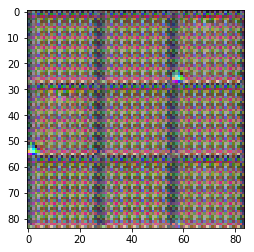

Epoch 0, Steps completed: 2320, Losses: Gntr 11.5154, Dsctr 0.0000
Epoch 0, Steps completed: 2340, Losses: Gntr 10.2875, Dsctr 0.0000
Epoch 0, Steps completed: 2360, Losses: Gntr 10.8043, Dsctr 0.0000
Epoch 0, Steps completed: 2380, Losses: Gntr 11.0334, Dsctr 0.0000
Epoch 0, Steps completed: 2400, Losses: Gntr 9.7875, Dsctr 0.0001


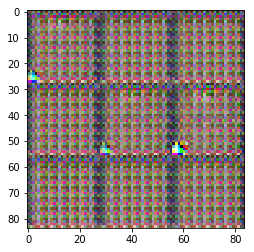

Epoch 0, Steps completed: 2420, Losses: Gntr 11.2753, Dsctr 0.0000
Epoch 0, Steps completed: 2440, Losses: Gntr 11.0314, Dsctr 0.0000
Epoch 0, Steps completed: 2460, Losses: Gntr 11.4719, Dsctr 0.0000
Epoch 0, Steps completed: 2480, Losses: Gntr 12.0731, Dsctr 0.0000
Epoch 0, Steps completed: 2500, Losses: Gntr 12.0136, Dsctr 0.0000


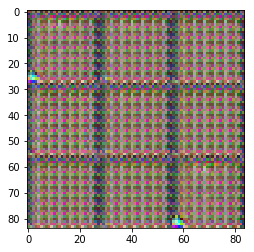

Epoch 0, Steps completed: 2520, Losses: Gntr 12.2699, Dsctr 0.0000
Epoch 0, Steps completed: 2540, Losses: Gntr 12.4215, Dsctr 0.0000
Epoch 0, Steps completed: 2560, Losses: Gntr 12.4214, Dsctr 0.0000
Epoch 0, Steps completed: 2580, Losses: Gntr 12.9306, Dsctr 0.0000
Epoch 0, Steps completed: 2600, Losses: Gntr 12.8032, Dsctr 0.0000


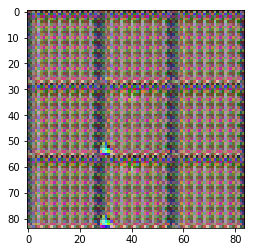

Epoch 0, Steps completed: 2620, Losses: Gntr 13.0480, Dsctr 0.0000
Epoch 0, Steps completed: 2640, Losses: Gntr 12.7117, Dsctr 0.0000
Epoch 0, Steps completed: 2660, Losses: Gntr 12.7188, Dsctr 0.0000
Epoch 0, Steps completed: 2680, Losses: Gntr 12.7143, Dsctr 0.0000
Epoch 0, Steps completed: 2700, Losses: Gntr 12.9452, Dsctr 0.0000


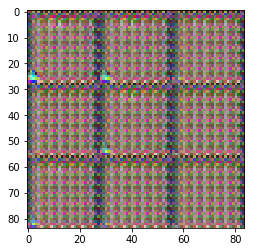

Epoch 0, Steps completed: 2720, Losses: Gntr 13.4255, Dsctr 0.0000
Epoch 0, Steps completed: 2740, Losses: Gntr 13.1159, Dsctr 0.0000
Epoch 0, Steps completed: 2760, Losses: Gntr 13.0872, Dsctr 0.0000
Epoch 0, Steps completed: 2780, Losses: Gntr 13.3191, Dsctr 0.0000
Epoch 0, Steps completed: 2800, Losses: Gntr 13.4156, Dsctr 0.0000


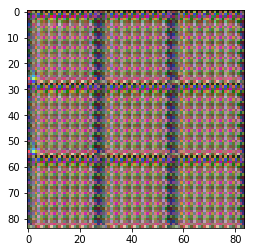

Epoch 0, Steps completed: 2820, Losses: Gntr 13.5487, Dsctr 0.0000
Epoch 0, Steps completed: 2840, Losses: Gntr 13.4595, Dsctr 0.0000
Epoch 0, Steps completed: 2860, Losses: Gntr 13.4855, Dsctr 0.0000
Epoch 0, Steps completed: 2880, Losses: Gntr 13.5429, Dsctr 0.0000
Epoch 0, Steps completed: 2900, Losses: Gntr 13.3679, Dsctr 0.0000


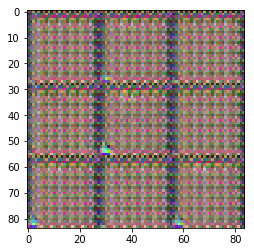

Epoch 0, Steps completed: 2920, Losses: Gntr 13.4143, Dsctr 0.0000
Epoch 0, Steps completed: 2940, Losses: Gntr 13.5338, Dsctr 0.0000
Epoch 0, Steps completed: 2960, Losses: Gntr 13.7549, Dsctr 0.0000
Epoch 0, Steps completed: 2980, Losses: Gntr 13.9118, Dsctr 0.0000
Epoch 0, Steps completed: 3000, Losses: Gntr 13.5599, Dsctr 0.0000


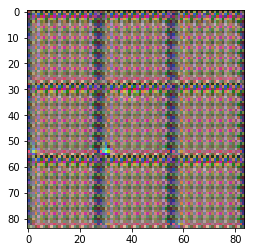

Epoch 0, Steps completed: 3020, Losses: Gntr 13.6855, Dsctr 0.0000
Epoch 0, Steps completed: 3040, Losses: Gntr 13.6891, Dsctr 0.0000
Epoch 0, Steps completed: 3060, Losses: Gntr 13.6991, Dsctr 0.0000
Epoch 0, Steps completed: 3080, Losses: Gntr 13.9187, Dsctr 0.0000
Epoch 0, Steps completed: 3100, Losses: Gntr 13.8075, Dsctr 0.0000


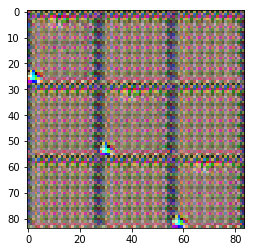

Epoch 0, Steps completed: 3120, Losses: Gntr 13.3817, Dsctr 0.0000
Epoch 0, Steps completed: 3140, Losses: Gntr 14.2696, Dsctr 0.0000
Epoch 0, Steps completed: 3160, Losses: Gntr 13.7659, Dsctr 0.0000


In [215]:
batch_size = 64
z_dim = 100
learning_rate = .002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.